In [4]:
# ALWAYS RUN THIS FIRST!
import os
import sys
from pathlib import Path

NOTEBOOK_DIR = Path("/rsrch9/home/plm/idso_fa1_pathology/codes/yshokrollahi/vitamin-p-latest")
os.chdir(NOTEBOOK_DIR)
sys.path.insert(0, str(NOTEBOOK_DIR))

print(f"✅ Working directory: {os.getcwd()}")

✅ Working directory: /rsrch9/home/plm/idso_fa1_pathology/codes/yshokrollahi/vitamin-p-latest


In [5]:
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
from PIL import Image

# Load the test set
tissuenet_path = Path("/rsrch9/home/plm/idso_fa1_pathology/TIER1/yasin-vitaminp/public-datasets/tissuenet_v1.1")
test_data = np.load(tissuenet_path / "tissuenet_v1.1_test.npz", allow_pickle=True)

print("📥 Loading TissueNet Test data...")

# Extract images and masks
images = test_data['X']  # Shape: (1324, 256, 256, 2) - 2 channels (nuclear + membrane)
masks = test_data['y']   # Shape: (1324, 256, 256, 2) - 2 channels (nuclear + whole-cell)
meta = test_data['meta'] # Metadata

print(f"\n✅ Loaded successfully!")
print(f"  Images shape: {images.shape} - dtype: {images.dtype}")
print(f"  Masks shape: {masks.shape} - dtype: {masks.dtype}")
print(f"  Number of samples: {len(images)}")

print(f"\n📊 Data characteristics:")
print(f"  Image channels: 2 (nuclear + membrane)")
print(f"  Mask channels: 2 (nuclear segmentation + whole-cell segmentation)")
print(f"  Image size: 256 x 256")
print(f"  Image value range: [{images.min():.1f}, {images.max():.1f}]")

# Analyze masks
print(f"\n🔬 Mask analysis (sample 0):")
nuclear_mask = masks[0, :, :, 0]
wholecell_mask = masks[0, :, :, 1]
print(f"  Nuclear instances: {nuclear_mask.max()}")
print(f"  Whole-cell instances: {wholecell_mask.max()}")

# Visualize one sample
fig, axes = plt.subplots(1, 4, figsize=(16, 4))

# Normalize image for display
img_display = images[0].copy()
for c in range(2):
    channel = img_display[:, :, c]
    if channel.max() > 0:
        p_low, p_high = np.percentile(channel[channel > 0], [1, 99])
        img_display[:, :, c] = np.clip((channel - p_low) / (p_high - p_low), 0, 1)

axes[0].imshow(img_display[:, :, 0], cmap='gray')
axes[0].set_title('Nuclear Channel')
axes[0].axis('off')

axes[1].imshow(img_display[:, :, 1], cmap='gray')
axes[1].set_title('Membrane Channel')
axes[1].axis('off')

axes[2].imshow(nuclear_mask, cmap='nipy_spectral')
axes[2].set_title(f'Nuclear Mask\n({nuclear_mask.max()} cells)')
axes[2].axis('off')

axes[3].imshow(wholecell_mask, cmap='nipy_spectral')
axes[3].set_title(f'Whole-Cell Mask\n({wholecell_mask.max()} cells)')
axes[3].axis('off')

plt.tight_layout()
plt.show()

print(f"\n📌 Note: TissueNet has 2 mask types:")
print(f"  - Channel 0: Nuclear segmentation")
print(f"  - Channel 1: Whole-cell segmentation")
print(f"  We'll evaluate nuclear segmentation using VitaminPFlex MIF nuclei branch")

📥 Loading TissueNet Test data...

✅ Loaded successfully!
  Images shape: (1324, 256, 256, 2) - dtype: float64
  Masks shape: (1324, 256, 256, 2) - dtype: int32
  Number of samples: 1324

📊 Data characteristics:
  Image channels: 2 (nuclear + membrane)
  Mask channels: 2 (nuclear segmentation + whole-cell segmentation)
  Image size: 256 x 256
  Image value range: [0.0, 95078.0]

🔬 Mask analysis (sample 0):
  Nuclear instances: 631
  Whole-cell instances: 363



📌 Note: TissueNet has 2 mask types:
  - Channel 0: Nuclear segmentation
  - Channel 1: Whole-cell segmentation
  We'll evaluate nuclear segmentation using VitaminPFlex MIF nuclei branch


Pool size: 1324 tiles available.

--- Stitching Indices: [881 862 907 972] ---

✅ Mosaic Created (512x512)
Data Type: uint16
Value Range: 0 - 65535
Total Unique Nuclei: 528 (excluding background)


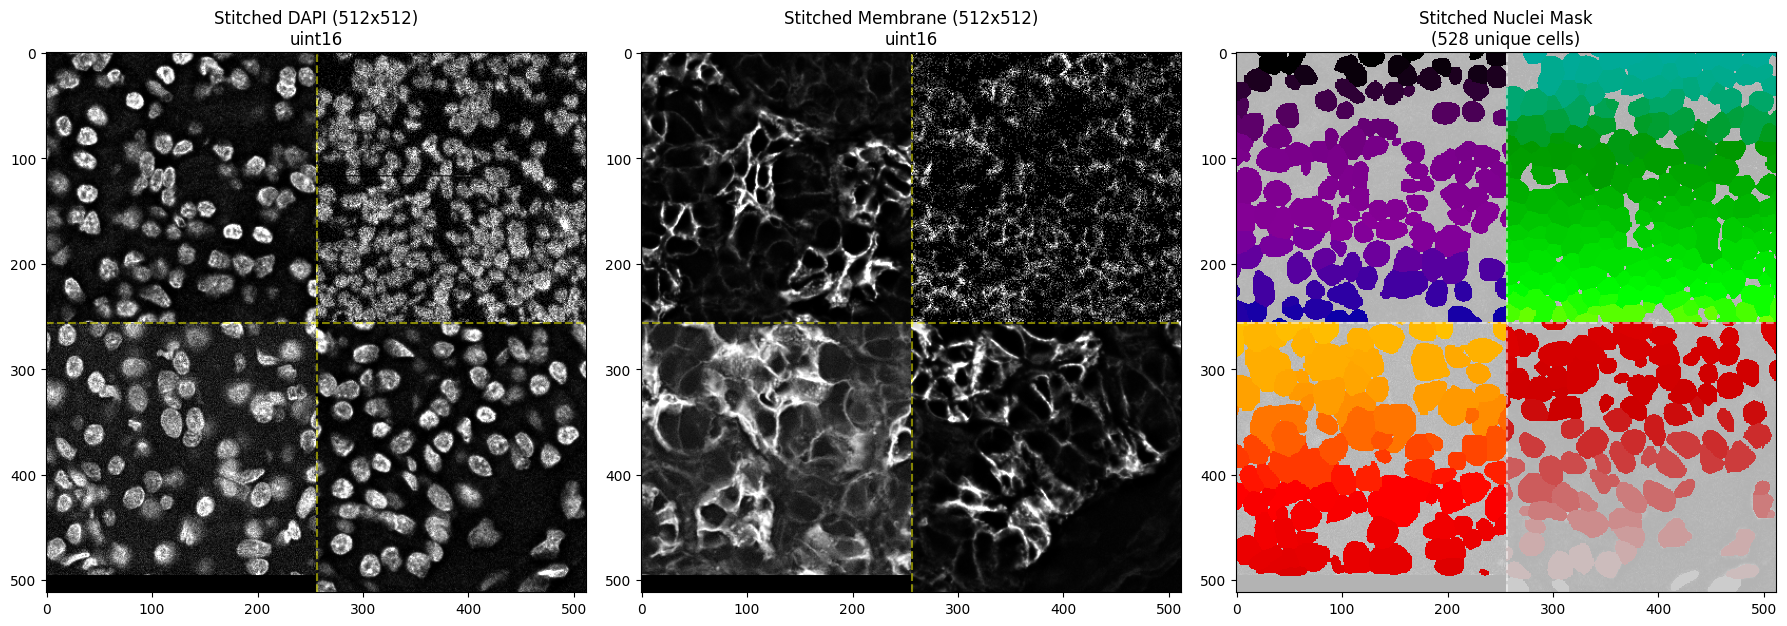

In [19]:
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path

# ---------------------------------------------------------------------
# 1. Load Data
# ---------------------------------------------------------------------
tissuenet_path = Path("/rsrch9/home/plm/idso_fa1_pathology/TIER1/yasin-vitaminp/public-datasets/tissuenet_v1.1")
data = np.load(tissuenet_path / "tissuenet_v1.1_test.npz", allow_pickle=True)

raw_images = data['X']  # (N, 256, 256, 2)
raw_masks = data['y']   # (N, 256, 256, 2)

print(f"Pool size: {len(raw_images)} tiles available.")

# ---------------------------------------------------------------------
# 2. Mosaic Stitching Function (CORRECTED for uint16)
# ---------------------------------------------------------------------
def create_mosaic_patch(indices, images, masks):
    """
    Stitches 4 TissueNet samples (256x256) into one 512x512 patch.
    indices: list of 4 integers [TL, TR, BL, BR]
    """
    # Initialize 512x512 arrays
    # CHANGE: Using uint16 to match Xenium format
    mosaic_img = np.zeros((512, 512, 2), dtype=np.uint16)
    mosaic_nuclei = np.zeros((512, 512), dtype=np.int32) # Use int32 for safety with IDs
    mosaic_cells = np.zeros((512, 512), dtype=np.int32)
    
    # Coordinates for the 4 quadrants
    # (y_start, y_end, x_start, x_end)
    quadrants = [
        (0, 256, 0, 256),       # Top-Left
        (0, 256, 256, 512),     # Top-Right
        (256, 512, 0, 256),     # Bottom-Left
        (256, 512, 256, 512)    # Bottom-Right
    ]
    
    current_max_nuclei_id = 0
    current_max_cell_id = 0
    
    print(f"\n--- Stitching Indices: {indices} ---")
    
    for i, idx in enumerate(indices):
        y1, y2, x1, x2 = quadrants[i]
        
        # Get source data
        src_img = images[idx]
        src_nuclei = masks[idx, :, :, 0]
        src_cell = masks[idx, :, :, 1]
        
        # --- A. Process Image (Normalize to uint16) ---
        img_uint16 = np.zeros_like(src_img, dtype=np.uint16)
        for c in range(2):
            ch = src_img[:, :, c]
            if ch.max() > ch.min():
                p1, p99 = np.percentile(ch, [1, 99])
                norm = np.clip((ch - p1) / (p99 - p1), 0, 1)
                # CHANGE: Scale to 65535 instead of 255
                img_uint16[:, :, c] = (norm * 65535).astype(np.uint16)
            else:
                img_uint16[:, :, c] = ch.astype(np.uint16)
        
        # Place Image
        mosaic_img[y1:y2, x1:x2] = img_uint16
        
        # --- B. Process Masks (Offset IDs to prevent collisions) ---
        # Nuclei
        nuclei_shifted = np.zeros_like(src_nuclei, dtype=np.int32)
        mask_active = src_nuclei > 0
        if np.any(mask_active):
            # Shift IDs by the current max so they don't clash with previous quadrants
            nuclei_shifted[mask_active] = src_nuclei[mask_active] + current_max_nuclei_id
            
        mosaic_nuclei[y1:y2, x1:x2] = nuclei_shifted
        
        # Cells
        cell_shifted = np.zeros_like(src_cell, dtype=np.int32)
        cell_active = src_cell > 0
        if np.any(cell_active):
            cell_shifted[cell_active] = src_cell[cell_active] + current_max_cell_id
            
        mosaic_cells[y1:y2, x1:x2] = cell_shifted
        
        # Update max IDs for the next quadrant
        if np.any(mask_active):
            current_max_nuclei_id += src_nuclei.max()
        if np.any(cell_active):
            current_max_cell_id += src_cell.max()
            
    return mosaic_img, mosaic_nuclei, mosaic_cells

# ---------------------------------------------------------------------
# 3. Test & Visualize
# ---------------------------------------------------------------------
# Pick 4 random indices
random_indices = np.random.choice(len(raw_images), 4, replace=False)
final_img, final_nuclei, final_cells = create_mosaic_patch(random_indices, raw_images, raw_masks)

print(f"\n✅ Mosaic Created (512x512)")
print(f"Data Type: {final_img.dtype}")
print(f"Value Range: {final_img.min()} - {final_img.max()}")
print(f"Total Unique Nuclei: {len(np.unique(final_nuclei)) - 1} (excluding background)")

# Visualization
fig, axes = plt.subplots(1, 3, figsize=(18, 6))

# Show DAPI channel (Nuclei)
# Note: Matplotlib handles uint16 automatically, but works best if we don't manually normalize for display here
axes[0].imshow(final_img[:, :, 0], cmap='gray')
axes[0].set_title(f"Stitched DAPI (512x512)\n{final_img.dtype}")
axes[0].axhline(256, color='yellow', linestyle='--', alpha=0.5)
axes[0].axvline(256, color='yellow', linestyle='--', alpha=0.5)

# Show Membrane channel
axes[1].imshow(final_img[:, :, 1], cmap='gray')
axes[1].set_title(f"Stitched Membrane (512x512)\n{final_img.dtype}")
axes[1].axhline(256, color='yellow', linestyle='--', alpha=0.5)
axes[1].axvline(256, color='yellow', linestyle='--', alpha=0.5)

# Show Nuclei Mask
masked_nuclei = np.ma.masked_where(final_nuclei == 0, final_nuclei)
axes[2].imshow(final_img[:, :, 0], cmap='gray', alpha=0.3) # Background reference
axes[2].imshow(masked_nuclei, cmap='nipy_spectral', interpolation='nearest')
axes[2].set_title(f"Stitched Nuclei Mask\n({len(np.unique(final_nuclei))-1} unique cells)")
axes[2].axhline(256, color='white', linestyle='--', alpha=0.5)
axes[2].axvline(256, color='white', linestyle='--', alpha=0.5)

plt.tight_layout()
plt.show()

Loading TissueNet...
🎲 Selected Random Indices: [ 229  865  347 1216]

SAVING TO ZARR: /rsrch9/home/plm/idso_fa1_pathology/TIER2/yasin-vitaminp/tissuenet/zarr_data/tissuenet_mosaic_0

✅ Saved Successfully!

VISUALIZING SAVED ZARR


/tmp/ipykernel_7551/2749155917.py:52: RuntimeWarning: divide by zero encountered in divide
  norm = np.clip((ch - p1) / (p99 - p1), 0, 1)
/tmp/ipykernel_7551/2749155917.py:52: RuntimeWarning: invalid value encountered in divide
  norm = np.clip((ch - p1) / (p99 - p1), 0, 1)
/tmp/ipykernel_7551/2749155917.py:53: RuntimeWarning: invalid value encountered in cast
  img_uint16[:, :, c] = (norm * 65535).astype(np.uint16)


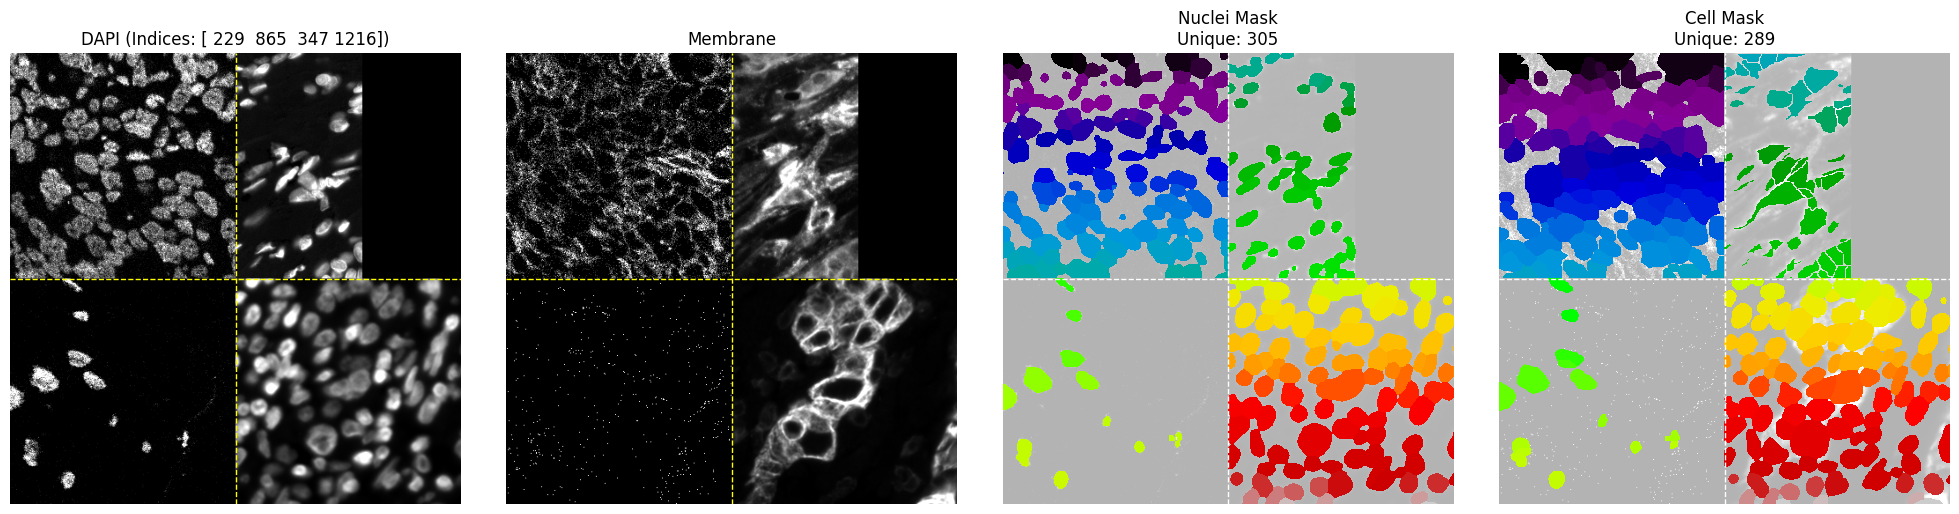

In [41]:
import os
import numpy as np
import zarr
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path

# ---------------------------------------------------------------------
# 1. Configuration
# ---------------------------------------------------------------------
tissuenet_path = Path("/rsrch9/home/plm/idso_fa1_pathology/TIER1/yasin-vitaminp/public-datasets/tissuenet_v1.1")
output_base_path = "/rsrch9/home/plm/idso_fa1_pathology/TIER2/yasin-vitaminp/tissuenet/zarr_data"
patch_size = 512

# ---------------------------------------------------------------------
# 2. Mosaic Stitching Function (SWAPPED CHANNELS)
# ---------------------------------------------------------------------
def create_mosaic_patch_uint16(indices, images, masks):
    # Initialize 512x512 arrays
    mosaic_img = np.zeros((512, 512, 2), dtype=np.uint16)
    mosaic_nuclei = np.zeros((512, 512), dtype=np.int32) 
    mosaic_cells = np.zeros((512, 512), dtype=np.int32)
    
    quadrants = [
        (0, 256, 0, 256),       # Top-Left
        (0, 256, 256, 512),     # Top-Right
        (256, 512, 0, 256),     # Bottom-Left
        (256, 512, 256, 512)    # Bottom-Right
    ]
    
    current_max_nuclei_id = 0
    current_max_cell_id = 0
    
    for i, idx in enumerate(indices):
        y1, y2, x1, x2 = quadrants[i]
        
        # Get source data
        src_img = images[idx]
        
        # --- SWAP FIX: Reversing the channels ---
        # Previous: Nuclei=0, Cell=1. 
        # New: Nuclei=1, Cell=0.
        src_nuclei = masks[idx, :, :, 1] 
        src_cell = masks[idx, :, :, 0]   
        
        # --- Normalize & Scale to uint16 (0 - 65535) ---
        img_uint16 = np.zeros_like(src_img, dtype=np.uint16)
        for c in range(2):
            ch = src_img[:, :, c]
            if ch.max() > ch.min():
                p1, p99 = np.percentile(ch, [1, 99])
                norm = np.clip((ch - p1) / (p99 - p1), 0, 1)
                img_uint16[:, :, c] = (norm * 65535).astype(np.uint16)
            else:
                img_uint16[:, :, c] = ch.astype(np.uint16)
        
        # --- Shift Mask IDs ---
        nuclei_shifted = np.zeros_like(src_nuclei, dtype=np.int32)
        mask_active = src_nuclei > 0
        if np.any(mask_active):
            nuclei_shifted[mask_active] = src_nuclei[mask_active] + current_max_nuclei_id
            
        cell_shifted = np.zeros_like(src_cell, dtype=np.int32)
        cell_active = src_cell > 0
        if np.any(cell_active):
            cell_shifted[cell_active] = src_cell[cell_active] + current_max_cell_id

        # --- Place in Mosaic ---
        mosaic_img[y1:y2, x1:x2] = img_uint16
        mosaic_nuclei[y1:y2, x1:x2] = nuclei_shifted
        mosaic_cells[y1:y2, x1:x2] = cell_shifted
        
        # Update offsets
        if np.any(mask_active):
            current_max_nuclei_id += src_nuclei.max()
        if np.any(cell_active):
            current_max_cell_id += src_cell.max()
            
    return mosaic_img, mosaic_nuclei, mosaic_cells

# ---------------------------------------------------------------------
# 3. Main Execution
# ---------------------------------------------------------------------
print(f"Loading TissueNet...")
data = np.load(tissuenet_path / "tissuenet_v1.1_test.npz", allow_pickle=True)
raw_images = data['X']
raw_masks = data['y']

# Define sample name and output
sample_name = "tissuenet_mosaic_0"
output_path = os.path.join(output_base_path, sample_name)
os.makedirs(os.path.join(output_path, 'mif'), exist_ok=True)

# --- RANDOM SELECTION ---
indices = np.random.choice(len(raw_images), 4, replace=False)
print(f"🎲 Selected Random Indices: {indices}")

# Generate Mosaic
final_img, final_nuclei, final_cells = create_mosaic_patch_uint16(indices, raw_images, raw_masks)

print(f"\n{'='*50}")
print(f"SAVING TO ZARR: {output_path}")
print(f"{'='*50}")

# 1. Images
mif_images_zarr = zarr.open(
    os.path.join(output_path, 'mif', 'images.zarr'),
    mode='w',
    shape=(1, patch_size, patch_size, 2),
    chunks=(1, patch_size, patch_size, 2),
    dtype='uint16',
    compressor=zarr.Blosc(cname='zstd', clevel=3)
)

# 2. Nuclei Masks
mif_nuclei_masks_zarr = zarr.open(
    os.path.join(output_path, 'mif', 'nuclei_masks.zarr'),
    mode='w',
    shape=(1, patch_size, patch_size),
    chunks=(1, patch_size, patch_size),
    dtype='int32',
    compressor=zarr.Blosc(cname='zstd', clevel=3)
)

# 3. Cell Masks
mif_cell_masks_zarr = zarr.open(
    os.path.join(output_path, 'mif', 'cell_masks.zarr'),
    mode='w',
    shape=(1, patch_size, patch_size),
    chunks=(1, patch_size, patch_size),
    dtype='int32',
    compressor=zarr.Blosc(cname='zstd', clevel=3)
)

# Write Data
mif_images_zarr[0] = final_img
mif_nuclei_masks_zarr[0] = final_nuclei
mif_cell_masks_zarr[0] = final_cells

# Metadata
metadata = [{
    'patch_idx': 0,
    'sample': sample_name,
    'source_indices': str(indices),
    'y_start': 0, 'y_end': 512, 
    'x_start': 0, 'x_end': 512
}]
pd.DataFrame(metadata).to_csv(os.path.join(output_path, 'mif', 'metadata.csv'), index=False)

print("\n✅ Saved Successfully!")

# ---------------------------------------------------------------------
# 4. Visualization Verification (4 Panels)
# ---------------------------------------------------------------------
print(f"\n{'='*50}")
print(f"VISUALIZING SAVED ZARR")
print(f"{'='*50}")

# Read back
saved_img = zarr.open(os.path.join(output_path, 'mif', 'images.zarr'), mode='r')[0]
saved_nuc = zarr.open(os.path.join(output_path, 'mif', 'nuclei_masks.zarr'), mode='r')[0]
saved_cell = zarr.open(os.path.join(output_path, 'mif', 'cell_masks.zarr'), mode='r')[0]

fig, axes = plt.subplots(1, 4, figsize=(20, 5))

# Panel 1: DAPI
axes[0].imshow(saved_img[:, :, 0], cmap='gray')
axes[0].set_title(f"DAPI (Indices: {indices})")
axes[0].axhline(256, color='yellow', linestyle='--', linewidth=1)
axes[0].axvline(256, color='yellow', linestyle='--', linewidth=1)
axes[0].axis('off')

# Panel 2: Membrane
axes[1].imshow(saved_img[:, :, 1], cmap='gray')
axes[1].set_title("Membrane")
axes[1].axhline(256, color='yellow', linestyle='--', linewidth=1)
axes[1].axvline(256, color='yellow', linestyle='--', linewidth=1)
axes[1].axis('off')

# Panel 3: Nuclei Mask
masked_nuc = np.ma.masked_where(saved_nuc == 0, saved_nuc)
axes[2].imshow(saved_img[:, :, 0], cmap='gray', alpha=0.3)
axes[2].imshow(masked_nuc, cmap='nipy_spectral', interpolation='nearest')
axes[2].set_title(f"Nuclei Mask\nUnique: {len(np.unique(saved_nuc))-1}")
axes[2].axhline(256, color='white', linestyle='--', linewidth=1)
axes[2].axvline(256, color='white', linestyle='--', linewidth=1)
axes[2].axis('off')

# Panel 4: Cell Mask
masked_cell = np.ma.masked_where(saved_cell == 0, saved_cell)
axes[3].imshow(saved_img[:, :, 1], cmap='gray', alpha=0.3)
axes[3].imshow(masked_cell, cmap='nipy_spectral', interpolation='nearest')
axes[3].set_title(f"Cell Mask\nUnique: {len(np.unique(saved_cell))-1}")
axes[3].axhline(256, color='white', linestyle='--', linewidth=1)
axes[3].axvline(256, color='white', linestyle='--', linewidth=1)
axes[3].axis('off')

plt.tight_layout()
plt.show()

🔎 Comparing against Xenium Sample: breast

STRUCTURAL COMPARISON (MIF MODALITY)
Metric               TissueNet (New)           Xenium (Reference)        Status    
--------------------------------------------------------------------------------
Dimensions (H,W,C)   (512, 512, 2)             (512, 512, 2)             ✅ Match   
Image Dtype          uint16                    uint16                    ✅ Match   
Mask Dtype           int32                     uint32                    ✅ Safe    
Pixel Range          (0, 65535)                (1, 11053)                ℹ️ Info   

VISUAL INTEGRITY CHECK


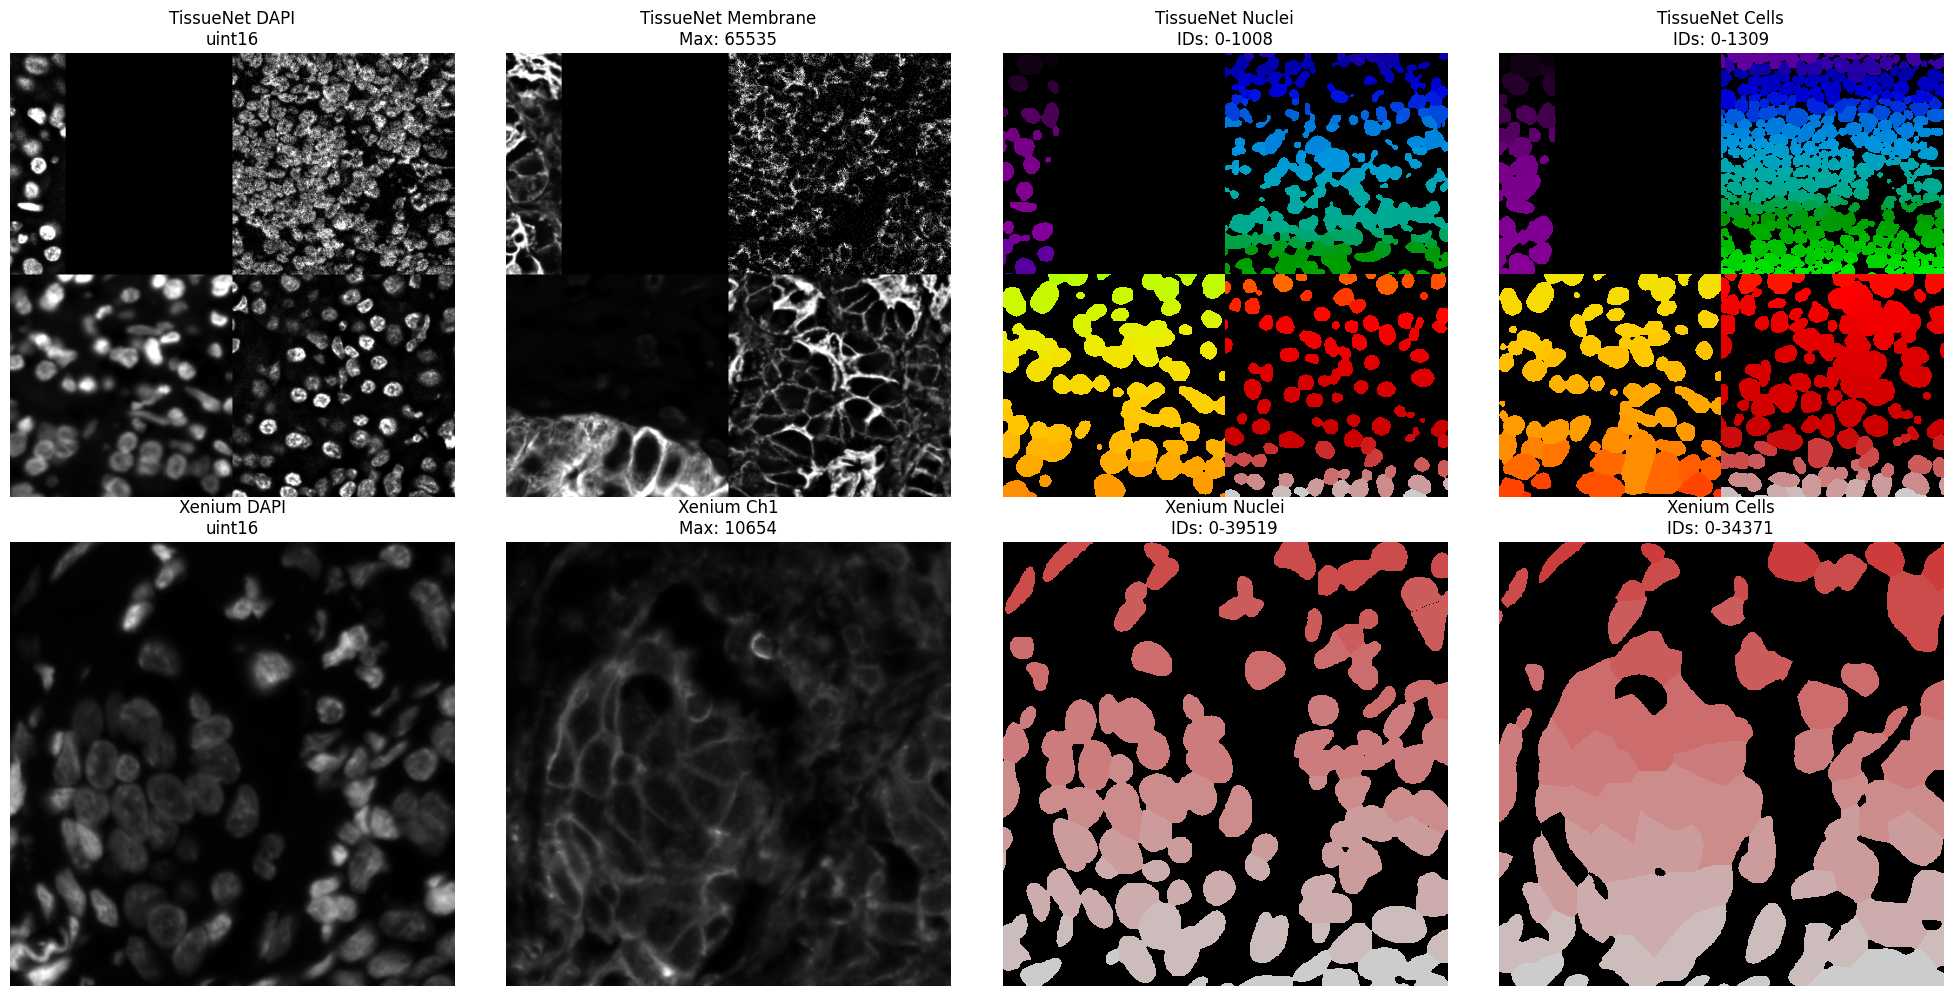


📝 COMPATIBILITY REPORT:
✅ PASS: The TissueNet arrays are STRUCTURALLY IDENTICAL to Xenium arrays.
   You can safely load them using the same dataloader.
   Note: Ensure your dataloader handles the missing 'he' folder gracefully.


In [39]:
import zarr
import numpy as np
import matplotlib.pyplot as plt
import os
import glob

# ---------------------------------------------------------------------
# 1. Configuration
# ---------------------------------------------------------------------
# Path to your NEW TissueNet Zarr
tissuenet_path = "/rsrch9/home/plm/idso_fa1_pathology/TIER2/yasin-vitaminp/tissuenet/zarr_data/tissuenet_mosaic_0"

# Path to your EXISTING Xenium Zarrs
xenium_base_path = "/rsrch9/home/plm/idso_fa1_pathology/TIER2/yasin-vitaminp/Xenium/zarr_data"

# Find the first available Xenium sample to compare against
xenium_samples = sorted([d for d in os.listdir(xenium_base_path) 
                        if os.path.isdir(os.path.join(xenium_base_path, d))])

if not xenium_samples:
    raise FileNotFoundError("No Xenium Zarr data found to compare against!")

xenium_sample_path = os.path.join(xenium_base_path, xenium_samples[0])
print(f"🔎 Comparing against Xenium Sample: {xenium_samples[0]}")

# ---------------------------------------------------------------------
# 2. Comparison Logic
# ---------------------------------------------------------------------
def get_zarr_info(path, modality='mif'):
    """Extracts critical metadata from a Zarr group."""
    info = {}
    target_path = os.path.join(path, modality)
    
    if not os.path.exists(target_path):
        return None
        
    try:
        # Open arrays
        img = zarr.open(os.path.join(target_path, 'images.zarr'), mode='r')
        nuc = zarr.open(os.path.join(target_path, 'nuclei_masks.zarr'), mode='r')
        cell = zarr.open(os.path.join(target_path, 'cell_masks.zarr'), mode='r')
        
        info['exists'] = True
        info['img_shape'] = img.shape
        info['img_dtype'] = img.dtype
        info['img_chunks'] = img.chunks
        info['mask_dtype'] = nuc.dtype
        
        # Get stats for the first patch to check value ranges
        info['img_range'] = (np.min(img[0]), np.max(img[0]))
        info['nuc_max_id'] = np.max(nuc[0])
        info['cell_max_id'] = np.max(cell[0])
        
        # Load sample patch for visualization
        info['sample_img'] = img[0]
        info['sample_nuc'] = nuc[0]
        info['sample_cell'] = cell[0]
        
    except Exception as e:
        info['error'] = str(e)
        
    return info

print("\n" + "="*60)
print("STRUCTURAL COMPARISON (MIF MODALITY)")
print("="*60)

tn_info = get_zarr_info(tissuenet_path)
xen_info = get_zarr_info(xenium_sample_path)

# Print Side-by-Side Table
headers = ["Metric", "TissueNet (New)", "Xenium (Reference)", "Status"]
row_fmt = "{:<20} {:<25} {:<25} {:<10}"

print(row_fmt.format(*headers))
print("-" * 80)

# 1. Image Dimensions
tn_dim = tn_info['img_shape'][1:] 
xen_dim = xen_info['img_shape'][1:]
status = "✅ Match" if tn_dim == xen_dim else "❌ Mismatch"
print(row_fmt.format("Dimensions (H,W,C)", str(tn_dim), str(xen_dim), status))

# 2. Data Type
status = "✅ Match" if tn_info['img_dtype'] == xen_info['img_dtype'] else "❌ Mismatch"
print(row_fmt.format("Image Dtype", str(tn_info['img_dtype']), str(xen_info['img_dtype']), status))

# 3. Mask Type
status = "✅ Safe" if np.issubdtype(tn_info['mask_dtype'], np.integer) and np.issubdtype(xen_info['mask_dtype'], np.integer) else "⚠️ Check"
print(row_fmt.format("Mask Dtype", str(tn_info['mask_dtype']), str(xen_info['mask_dtype']), status))

# 4. Value Range
print(row_fmt.format("Pixel Range", str(tn_info['img_range']), str(xen_info['img_range']), "ℹ️ Info"))

# ---------------------------------------------------------------------
# 3. Visual Verification (Now with 4 Columns)
# ---------------------------------------------------------------------
print("\n" + "="*60)
print("VISUAL INTEGRITY CHECK")
print("="*60)

# Create 2 rows (TN vs Xenium) and 4 columns (DAPI, Mem, Nuc Mask, Cell Mask)
fig, axes = plt.subplots(2, 4, figsize=(20, 10))

# --- Row 1: TissueNet ---
tn_img = tn_info['sample_img']
tn_nuc = tn_info['sample_nuc']
tn_cell = tn_info['sample_cell']

# 1. DAPI
axes[0, 0].imshow(tn_img[:, :, 0], cmap='gray')
axes[0, 0].set_title(f"TissueNet DAPI\n{tn_img.dtype}")
axes[0, 0].axis('off')

# 2. Membrane
axes[0, 1].imshow(tn_img[:, :, 1], cmap='gray')
axes[0, 1].set_title(f"TissueNet Membrane\nMax: {tn_img[:,:,1].max()}")
axes[0, 1].axis('off')

# 3. Nuclei Mask
axes[0, 2].imshow(tn_nuc, cmap='nipy_spectral', interpolation='nearest')
axes[0, 2].set_title(f"TissueNet Nuclei\nIDs: 0-{tn_info['nuc_max_id']}")
axes[0, 2].axis('off')

# 4. Cell Mask (NEW)
axes[0, 3].imshow(tn_cell, cmap='nipy_spectral', interpolation='nearest')
axes[0, 3].set_title(f"TissueNet Cells\nIDs: 0-{tn_info['cell_max_id']}")
axes[0, 3].axis('off')


# --- Row 2: Xenium ---
xen_img = xen_info['sample_img']
xen_nuc = xen_info['sample_nuc']
xen_cell = xen_info['sample_cell']

# 1. DAPI
axes[1, 0].imshow(xen_img[:, :, 0], cmap='gray')
axes[1, 0].set_title(f"Xenium DAPI\n{xen_img.dtype}")
axes[1, 0].axis('off')

# 2. Membrane (Check if exists)
if xen_img.shape[2] > 1:
    axes[1, 1].imshow(xen_img[:, :, 1], cmap='gray')
    axes[1, 1].set_title(f"Xenium Ch1\nMax: {xen_img[:,:,1].max()}")
else:
    axes[1, 1].text(0.5, 0.5, "No 2nd Channel", ha='center')
axes[1, 1].axis('off')

# 3. Nuclei Mask
axes[1, 2].imshow(xen_nuc, cmap='nipy_spectral', interpolation='nearest')
axes[1, 2].set_title(f"Xenium Nuclei\nIDs: 0-{xen_info['nuc_max_id']}")
axes[1, 2].axis('off')

# 4. Cell Mask (NEW)
axes[1, 3].imshow(xen_cell, cmap='nipy_spectral', interpolation='nearest')
axes[1, 3].set_title(f"Xenium Cells\nIDs: 0-{xen_info['cell_max_id']}")
axes[1, 3].axis('off')

plt.tight_layout()
plt.show()

# ---------------------------------------------------------------------
# 4. Final Report
# ---------------------------------------------------------------------
print("\n📝 COMPATIBILITY REPORT:")
if tn_dim == xen_dim and tn_info['img_dtype'] == xen_info['img_dtype']:
    print("✅ PASS: The TissueNet arrays are STRUCTURALLY IDENTICAL to Xenium arrays.")
    print("   You can safely load them using the same dataloader.")
    print("   Note: Ensure your dataloader handles the missing 'he' folder gracefully.")
else:
    print("❌ FAIL: Structural mismatch detected. Do not combine datasets yet.")

In [40]:
import zarr
import numpy as np
import matplotlib.pyplot as plt
import os

# ---------------------------------------------------------------------
# 1. Configuration
# ---------------------------------------------------------------------
tissuenet_path = "/rsrch9/home/plm/idso_fa1_pathology/TIER2/yasin-vitaminp/tissuenet/zarr_data/tissuenet_mosaic_0"

# ---------------------------------------------------------------------
# 2. Advanced Verification Logic
# ---------------------------------------------------------------------
def verify_mosaic_structure(path):
    print(f"🔎 Inspecting: {path}")
    
    # Open the Zarr arrays
    try:
        img_zarr = zarr.open(os.path.join(path, 'mif', 'images.zarr'), mode='r')
        nuc_zarr = zarr.open(os.path.join(path, 'mif', 'nuclei_masks.zarr'), mode='r')
    except Exception as e:
        print(f"❌ Error opening Zarr: {e}")
        return

    # Load the first patch (512x512)
    img = img_zarr[0]      # Shape (512, 512, 2)
    masks = nuc_zarr[0]    # Shape (512, 512)

    print(f"\n📊 Image Shape: {img.shape}")
    print(f"📊 Data Type:   {img.dtype}")
    print(f"📊 Intensity:    Min={img.min()}, Max={img.max()} (Target: 0-65535)")

    # --- Check 4 Quadrants ---
    # We define the 4 regions to verify they all contain data
    quadrants = {
        "Top-Left (0-256, 0-256)": img[0:256, 0:256],
        "Top-Right (0-256, 256:512)": img[0:256, 256:512],
        "Btm-Left (256:512, 0-256)": img[256:512, 0:256],
        "Btm-Right (256:512, 256:512)": img[256:512, 256:512]
    }

    print(f"\n🧩 Mosaic Quadrant Check:")
    all_filled = True
    for name, quad in quadrants.items():
        mean_val = np.mean(quad)
        has_data = mean_val > 0
        status = "✅ Has Data" if has_data else "❌ EMPTY (Black)"
        print(f"  - {name}: {status} (Mean intensity: {mean_val:.1f})")
        if not has_data:
            all_filled = False
    
    if all_filled:
        print("\n✅ SUCCESS: All 4 quadrants contain image data.")
    else:
        print("\n❌ FAILURE: One or more quadrants are empty.")

    # --- Visualization with Grid ---
    fig, axes = plt.subplots(1, 2, figsize=(12, 6))
    
    # 1. DAPI Channel
    axes[0].imshow(img[:, :, 0], cmap='gray')
    axes[0].set_title(f"DAPI Channel (Stitched)\n{img.dtype}")
    # Draw Yellow Grid Lines to show stitching
    axes[0].axhline(256, color='yellow', linestyle='--', linewidth=2)
    axes[0].axvline(256, color='yellow', linestyle='--', linewidth=2)
    
    # 2. Nuclei Masks
    # Mask out background (0) for better visibility
    masked_nuc = np.ma.masked_where(masks == 0, masks)
    axes[1].imshow(img[:, :, 0], cmap='gray', alpha=0.3) # Background
    axes[1].imshow(masked_nuc, cmap='nipy_spectral', interpolation='nearest')
    axes[1].set_title(f"Nuclei Masks\nTotal Cells: {len(np.unique(masks))-1}")
    axes[1].axhline(256, color='white', linestyle='--', linewidth=2)
    axes[1].axvline(256, color='white', linestyle='--', linewidth=2)

    plt.tight_layout()
    plt.show()

# Run verification
verify_mosaic_structure(tissuenet_path)

🔎 Inspecting: /rsrch9/home/plm/idso_fa1_pathology/TIER2/yasin-vitaminp/tissuenet/zarr_data/tissuenet_mosaic_0

📊 Image Shape: (512, 512, 2)
📊 Data Type:   uint16
📊 Intensity:    Min=0, Max=65535 (Target: 0-65535)

🧩 Mosaic Quadrant Check:
  - Top-Left (0-256, 0-256): ✅ Has Data (Mean intensity: 3857.8)
  - Top-Right (0-256, 256:512): ✅ Has Data (Mean intensity: 12779.8)
  - Btm-Left (256:512, 0-256): ✅ Has Data (Mean intensity: 10944.6)
  - Btm-Right (256:512, 256:512): ✅ Has Data (Mean intensity: 11533.8)

✅ SUCCESS: All 4 quadrants contain image data.


## whole tissue net

In [44]:
import os
import numpy as np
import zarr
import pandas as pd
from pathlib import Path
from concurrent.futures import ProcessPoolExecutor
from tqdm import tqdm
import math

# ---------------------------------------------------------------------
# 1. Configuration
# ---------------------------------------------------------------------
tissuenet_base = Path("/rsrch9/home/plm/idso_fa1_pathology/TIER1/yasin-vitaminp/public-datasets/tissuenet_v1.1")
datasets = {
    "train": tissuenet_base / "tissuenet_v1.1_train.npz",
    "val":   tissuenet_base / "tissuenet_v1.1_val.npz",
    "test":  tissuenet_base / "tissuenet_v1.1_test.npz"
}

output_base_path = Path("/rsrch9/home/plm/idso_fa1_pathology/TIER2/yasin-vitaminp/tissuenet/zarr_data")
patch_size = 512
num_workers = 64 

# ---------------------------------------------------------------------
# 2. Worker Functions
# ---------------------------------------------------------------------

def normalize_to_uint16(arr):
    """Normalize a (H, W, 2) array to uint16 (0-65535) efficiently."""
    out = np.zeros_like(arr, dtype=np.uint16)
    for c in range(2):
        ch = arr[:, :, c]
        c_max, c_min = ch.max(), ch.min()
        if c_max > c_min:
            p1, p99 = np.percentile(ch, [1, 99])
            norm = np.clip((ch - p1) / (p99 - p1), 0, 1)
            out[:, :, c] = (norm * 65535).astype(np.uint16)
        else:
            out[:, :, c] = ch.astype(np.uint16)
    return out

def save_zarr_sample(path, img, nuc, cell, metadata):
    """Helper to write Zarr files to disk."""
    os.makedirs(path / 'mif', exist_ok=True)
    
    # 1. Images
    z_img = zarr.open(path / 'mif' / 'images.zarr', mode='w', shape=(1, 512, 512, 2), chunks=(1, 512, 512, 2), dtype='uint16', compressor=zarr.Blosc(cname='zstd', clevel=3))
    z_img[0] = img

    # 2. Nuclei
    z_nuc = zarr.open(path / 'mif' / 'nuclei_masks.zarr', mode='w', shape=(1, 512, 512), chunks=(1, 512, 512), dtype='int32', compressor=zarr.Blosc(cname='zstd', clevel=3))
    z_nuc[0] = nuc

    # 3. Cells
    z_cell = zarr.open(path / 'mif' / 'cell_masks.zarr', mode='w', shape=(1, 512, 512), chunks=(1, 512, 512), dtype='int32', compressor=zarr.Blosc(cname='zstd', clevel=3))
    z_cell[0] = cell
    
    # Metadata
    pd.DataFrame([metadata]).to_csv(path / 'mif' / 'metadata.csv', index=False)


def process_mosaic_batch(args):
    """STRATEGY A: Stitch 4 (256x256) images into 1 (512x512)"""
    mosaic_idx, tile_indices, split_name, output_dir, images_chunk, masks_chunk = args
    
    sample_name = f"tissuenet_mosaic_{mosaic_idx}"
    sample_path = output_dir / sample_name
    
    mosaic_img = np.zeros((512, 512, 2), dtype=np.uint16)
    mosaic_nuclei = np.zeros((512, 512), dtype=np.int32)
    mosaic_cells = np.zeros((512, 512), dtype=np.int32)
    
    quadrants = [(0, 256, 0, 256), (0, 256, 256, 512), (256, 512, 0, 256), (256, 512, 256, 512)]
    
    curr_nuc_id = 0
    curr_cell_id = 0
    filled_count = 0
    
    for i, relative_idx in enumerate(tile_indices):
        if relative_idx is None: continue # Padding
        
        y1, y2, x1, x2 = quadrants[i]
        src_img = images_chunk[relative_idx] # (256, 256, 2)
        
        # SWAP: Nuclei=1, Cell=0
        src_nuclei = masks_chunk[relative_idx, :, :, 1]
        src_cell = masks_chunk[relative_idx, :, :, 0]
        
        # Process
        img_uint16 = normalize_to_uint16(src_img)
        
        # Shift IDs
        nuc_shifted = np.zeros_like(src_nuclei, dtype=np.int32)
        mask_active = src_nuclei > 0
        if np.any(mask_active):
            nuc_shifted[mask_active] = src_nuclei[mask_active] + curr_nuc_id
            
        cell_shifted = np.zeros_like(src_cell, dtype=np.int32)
        cell_active = src_cell > 0
        if np.any(cell_active):
            cell_shifted[cell_active] = src_cell[cell_active] + curr_cell_id

        # Place
        mosaic_img[y1:y2, x1:x2] = img_uint16
        mosaic_nuclei[y1:y2, x1:x2] = nuc_shifted
        mosaic_cells[y1:y2, x1:x2] = cell_shifted
        
        # Update offsets
        if np.any(mask_active): curr_nuc_id += src_nuclei.max()
        if np.any(cell_active): curr_cell_id += src_cell.max()
        filled_count += 1
        
    meta = {'patch_idx': 0, 'sample': sample_name, 'split': split_name, 'type': 'mosaic_4x_256'}
    save_zarr_sample(sample_path, mosaic_img, mosaic_nuclei, mosaic_cells, meta)
    return True


def process_direct_batch(args):
    """STRATEGY B: Save 1 (512x512) image directly"""
    global_idx, relative_idx, split_name, output_dir, images_chunk, masks_chunk = args
    
    sample_name = f"tissuenet_sample_{global_idx}"
    sample_path = output_dir / sample_name
    
    # Get Data
    src_img = images_chunk[relative_idx] # (512, 512, 2)
    
    # SWAP: Nuclei=1, Cell=0
    src_nuclei = masks_chunk[relative_idx, :, :, 1].astype(np.int32)
    src_cell = masks_chunk[relative_idx, :, :, 0].astype(np.int32)
    
    # Normalize
    img_uint16 = normalize_to_uint16(src_img)
    
    meta = {'patch_idx': 0, 'sample': sample_name, 'split': split_name, 'type': 'direct_512'}
    save_zarr_sample(sample_path, img_uint16, src_nuclei, src_cell, meta)
    return True

# ---------------------------------------------------------------------
# 3. Main Processing Loop
# ---------------------------------------------------------------------
if __name__ == "__main__":
    
    print(f"{'='*60}")
    print(f"🚀 ADAPTIVE TISSUENET CONVERSION (256px -> Mosaic, 512px -> Direct)")
    print(f"   Workers: {num_workers}")
    print(f"{'='*60}")
    
    for split, npz_path in datasets.items():
        if not npz_path.exists():
            print(f"⚠️ Skipping {split}: File not found")
            continue
            
        print(f"\n📥 Loading {split} dataset...")
        try:
            # Load Data
            data = np.load(npz_path, allow_pickle=True)
            images = data['X']
            masks = data['y']
            num_samples = len(images)
            
            # DETECT SHAPE
            img_h, img_w = images.shape[1], images.shape[2]
            print(f"   Shape Detected: {images.shape} (N, H, W, C)")
            
            split_output_dir = output_base_path / split
            os.makedirs(split_output_dir, exist_ok=True)
            
            tasks = []
            
            # --- STRATEGY SELECTION ---
            if img_h == 256 and img_w == 256:
                print(f"   👉 Strategy: MOSAIC (Stitching 4 tiles -> 1 sample)")
                
                # Create batches of 4
                for mosaic_idx, start_idx in enumerate(range(0, num_samples, 4)):
                    batch_indices = []
                    for k in range(4):
                        idx = start_idx + k
                        batch_indices.append(idx if idx < num_samples else None)
                    
                    # Create Chunk
                    valid_indices = [x for x in batch_indices if x is not None]
                    img_chunk = images[valid_indices]
                    msk_chunk = masks[valid_indices]
                    rel_indices = [i if idx is not None else None for i, idx in enumerate(batch_indices)]
                    
                    tasks.append((mosaic_idx, rel_indices, split, split_output_dir, img_chunk, msk_chunk))
                
                worker_fn = process_mosaic_batch
                
            elif img_h == 512 and img_w == 512:
                print(f"   👉 Strategy: DIRECT (Saving 1 tile -> 1 sample)")
                
                # Create batches of 1 (Direct)
                for i in range(num_samples):
                    # We pass chunks of 1 to keep logic similar (chunks are fast refs in numpy)
                    # To minimize pickling overhead, we can pass bigger chunks, but let's keep it simple for now
                    # Passing single items is cleaner logic
                    img_chunk = images[i:i+1]
                    msk_chunk = masks[i:i+1]
                    tasks.append((i, 0, split, split_output_dir, img_chunk, msk_chunk))
                    
                worker_fn = process_direct_batch
                
            else:
                print(f"❌ ERROR: Unexpected dimensions {img_h}x{img_w}. Expected 256 or 512.")
                continue

            print(f"   Processing {len(tasks)} samples...")
            
            # Execute
            with ProcessPoolExecutor(max_workers=num_workers) as executor:
                list(tqdm(
                    executor.map(worker_fn, tasks), 
                    total=len(tasks),
                    desc=f"Converting {split}"
                ))
            
            # Cleanup
            del images, masks, data
            import gc; gc.collect()
            
        except Exception as e:
            print(f"❌ Critical Error processing {split}: {e}")
            import traceback
            traceback.print_exc()

    print(f"\n{'='*60}")
    print("🎉 ALL DONE")

🚀 ADAPTIVE TISSUENET CONVERSION (256px -> Mosaic, 512px -> Direct)
   Workers: 64

📥 Loading train dataset...
   Shape Detected: (2580, 512, 512, 2) (N, H, W, C)
   👉 Strategy: DIRECT (Saving 1 tile -> 1 sample)
   Processing 2580 samples...


Converting train:   9%|▉         | 231/2580 [00:03<00:24, 94.14it/s]/tmp/ipykernel_7551/1840723115.py:36: RuntimeWarning: divide by zero encountered in divide
  norm = np.clip((ch - p1) / (p99 - p1), 0, 1)
/tmp/ipykernel_7551/1840723115.py:36: RuntimeWarning: invalid value encountered in divide
  norm = np.clip((ch - p1) / (p99 - p1), 0, 1)
/tmp/ipykernel_7551/1840723115.py:37: RuntimeWarning: invalid value encountered in cast
  out[:, :, c] = (norm * 65535).astype(np.uint16)
Converting train: 100%|██████████| 2580/2580 [00:32<00:00, 78.43it/s]



📥 Loading val dataset...
   Shape Detected: (3118, 256, 256, 2) (N, H, W, C)
   👉 Strategy: MOSAIC (Stitching 4 tiles -> 1 sample)
   Processing 780 samples...


Converting val: 100%|██████████| 780/780 [00:09<00:00, 79.47it/s] 



📥 Loading test dataset...
   Shape Detected: (1324, 256, 256, 2) (N, H, W, C)
   👉 Strategy: MOSAIC (Stitching 4 tiles -> 1 sample)
   Processing 331 samples...


Converting test:  14%|█▎        | 45/331 [00:00<00:05, 57.17it/s]/tmp/ipykernel_7551/1840723115.py:36: RuntimeWarning: divide by zero encountered in divide
  norm = np.clip((ch - p1) / (p99 - p1), 0, 1)
Converting test:  16%|█▌        | 52/331 [00:01<00:04, 60.45it/s]/tmp/ipykernel_7551/1840723115.py:36: RuntimeWarning: invalid value encountered in divide
  norm = np.clip((ch - p1) / (p99 - p1), 0, 1)
/tmp/ipykernel_7551/1840723115.py:37: RuntimeWarning: invalid value encountered in cast
  out[:, :, c] = (norm * 65535).astype(np.uint16)
/tmp/ipykernel_7551/1840723115.py:36: RuntimeWarning: divide by zero encountered in divide
  norm = np.clip((ch - p1) / (p99 - p1), 0, 1)
/tmp/ipykernel_7551/1840723115.py:36: RuntimeWarning: invalid value encountered in divide
  norm = np.clip((ch - p1) / (p99 - p1), 0, 1)
/tmp/ipykernel_7551/1840723115.py:37: RuntimeWarning: invalid value encountered in cast
  out[:, :, c] = (norm * 65535).astype(np.uint16)
/tmp/ipykernel_7551/1840723115.py:36: Runtim


🎉 ALL DONE



🔎 INSPECTING TRAIN: tissuenet_sample_2036
  Shape: (512, 512, 2)
  Range: 0 - 65535 (dtype: uint16)
  Unique Nuclei: 278
  Unique Cells:  294


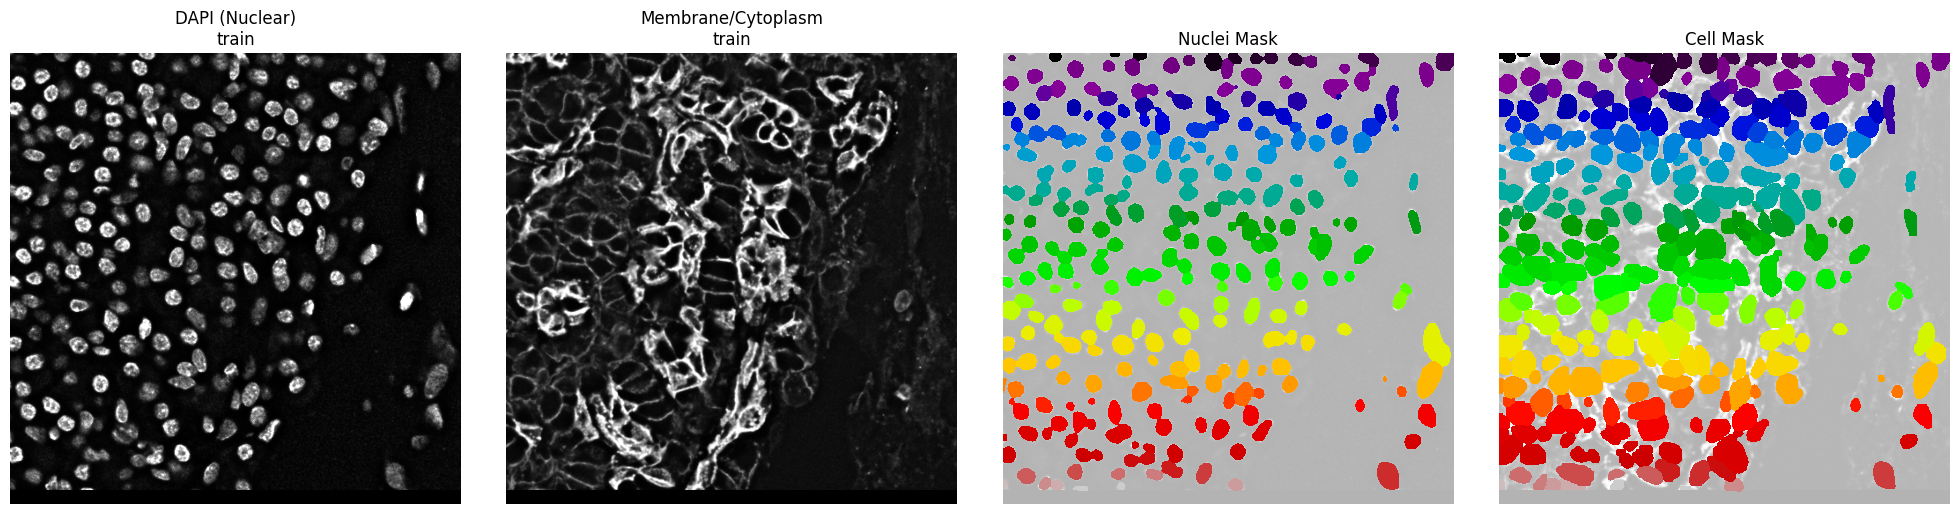


🔎 INSPECTING VAL: tissuenet_mosaic_86
  Shape: (512, 512, 2)
  Range: 0 - 65535 (dtype: uint16)
  Unique Nuclei: 86
  Unique Cells:  173


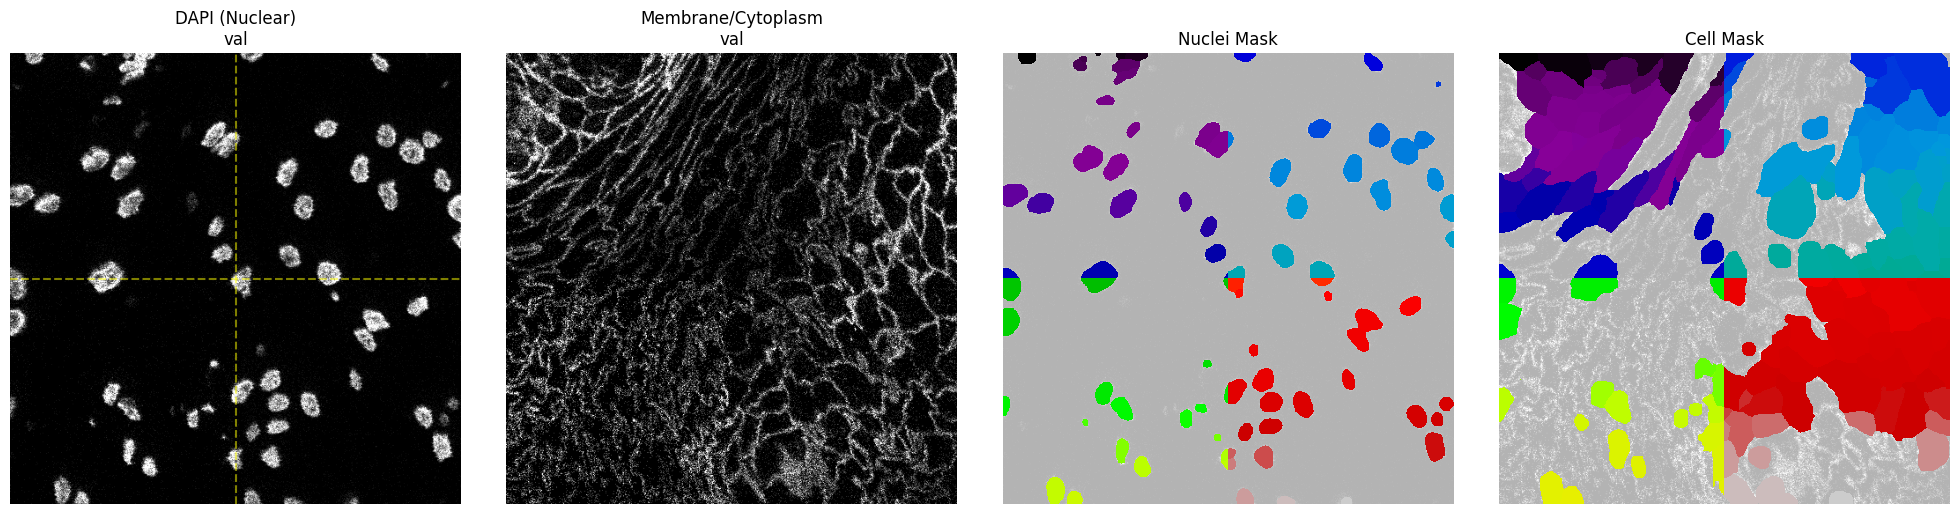


🔎 INSPECTING TEST: tissuenet_mosaic_105
  Shape: (512, 512, 2)
  Range: 0 - 65535 (dtype: uint16)
  Unique Nuclei: 1018
  Unique Cells:  982


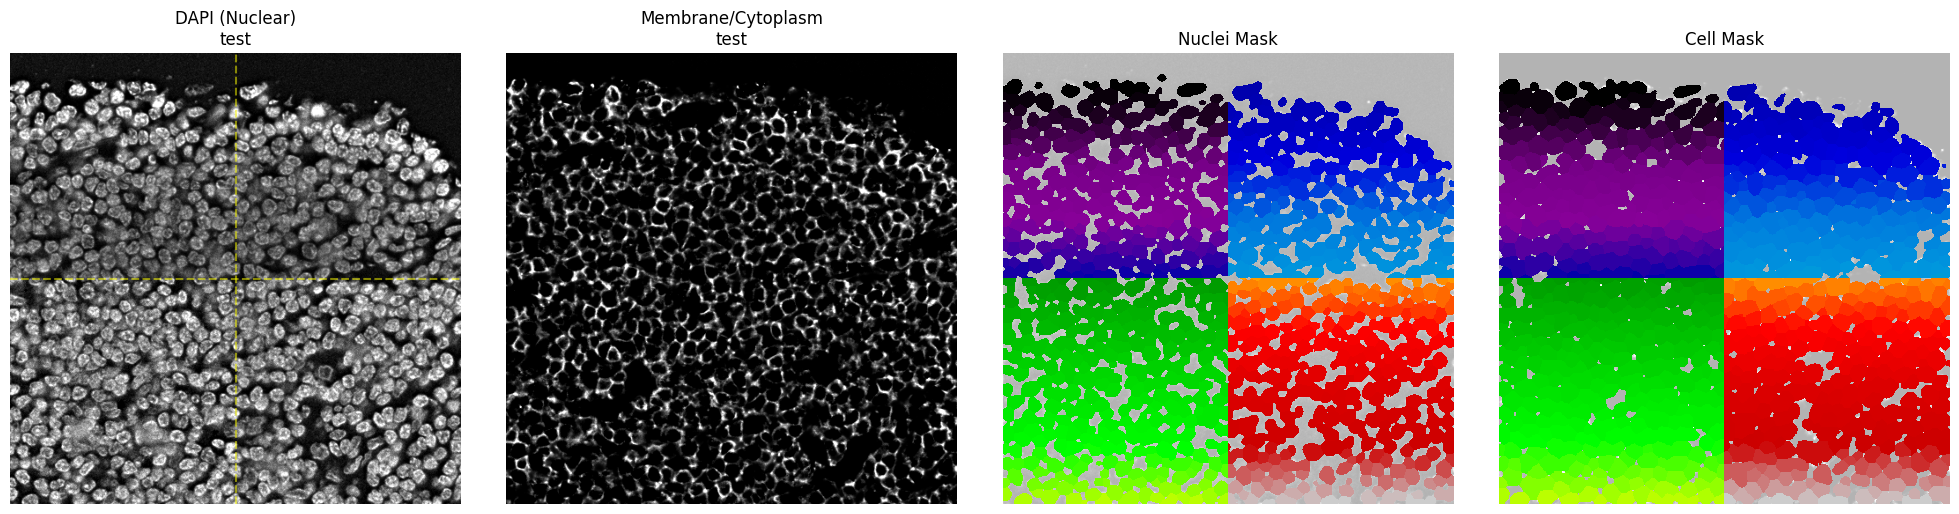

In [67]:
import os
import random
import zarr
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
import glob

# ---------------------------------------------------------------------
# 1. Configuration
# ---------------------------------------------------------------------
output_base_path = Path("/rsrch9/home/plm/idso_fa1_pathology/TIER2/yasin-vitaminp/tissuenet/zarr_data")

# ---------------------------------------------------------------------
# 2. Visualization Function
# ---------------------------------------------------------------------
def visualize_random_sample(split_name):
    split_dir = output_base_path / split_name
    
    # Find all samples in this split directory
    samples = sorted(list(split_dir.glob("*")))
    
    if not samples:
        print(f"⚠️ No samples found in {split_name}!")
        return

    # Pick a random sample
    sample_path = random.choice(samples)
    print(f"\n{'='*60}")
    print(f"🔎 INSPECTING {split_name.upper()}: {sample_path.name}")
    print(f"{'='*60}")

    try:
        # Load Zarrs
        img = zarr.open(sample_path / 'mif' / 'images.zarr', mode='r')[0]
        nuc = zarr.open(sample_path / 'mif' / 'nuclei_masks.zarr', mode='r')[0]
        cell = zarr.open(sample_path / 'mif' / 'cell_masks.zarr', mode='r')[0]

        print(f"  Shape: {img.shape}")
        print(f"  Range: {img.min()} - {img.max()} (dtype: {img.dtype})")
        print(f"  Unique Nuclei: {len(np.unique(nuc)) - 1}")
        print(f"  Unique Cells:  {len(np.unique(cell)) - 1}")

        # --- PLOTTING ---
        fig, axes = plt.subplots(1, 4, figsize=(20, 5))
        
        # 1. DAPI (Channel 0)
        axes[0].imshow(img[:, :, 0], cmap='gray')
        axes[0].set_title(f"DAPI (Nuclear)\n{split_name}")
        axes[0].axis('off')
        # Add stitching grid only for mosaics (Test/Val)
        if split_name in ['test', 'val']:
            axes[0].axhline(256, color='yellow', linestyle='--', alpha=0.5)
            axes[0].axvline(256, color='yellow', linestyle='--', alpha=0.5)

        # 2. Membrane (Channel 1)
        axes[1].imshow(img[:, :, 1], cmap='gray')
        axes[1].set_title(f"Membrane/Cytoplasm\n{split_name}")
        axes[1].axis('off')

        # 3. Nuclei Mask (Colorized)
        masked_nuc = np.ma.masked_where(nuc == 0, nuc)
        axes[2].imshow(img[:, :, 0], cmap='gray', alpha=0.3)
        axes[2].imshow(masked_nuc, cmap='nipy_spectral', interpolation='nearest')
        axes[2].set_title(f"Nuclei Mask")
        axes[2].axis('off')

        # 4. Cell Mask (Colorized)
        masked_cell = np.ma.masked_where(cell == 0, cell)
        axes[3].imshow(img[:, :, 1], cmap='gray', alpha=0.3)
        axes[3].imshow(masked_cell, cmap='nipy_spectral', interpolation='nearest')
        axes[3].set_title(f"Cell Mask")
        axes[3].axis('off')

        plt.tight_layout()
        plt.show()

    except Exception as e:
        print(f"❌ Error loading {sample_path.name}: {e}")

# ---------------------------------------------------------------------
# 3. Run Checks
# ---------------------------------------------------------------------
# Check one random sample from each split
visualize_random_sample("train")  # Should be direct 512px
visualize_random_sample("val")    # Should be mosaic 4x256px
visualize_random_sample("test")   # Should be mosaic 4x256px

In [65]:
import numpy as np
from pathlib import Path

# ---------------------------------------------------------------------
# Configuration
# ---------------------------------------------------------------------
base_path = Path("/rsrch9/home/plm/idso_fa1_pathology/TIER1/yasin-vitaminp/public-datasets/tissuenet_v1.1")
files = {
    "Train": "tissuenet_v1.1_train.npz",
    "Val":   "tissuenet_v1.1_val.npz",
    "Test":  "tissuenet_v1.1_test.npz"
}

print(f"{'Split':<10} | {'Images (X) Shape':<25} | {'Masks (y) Shape':<25} | {'Resolution'}")
print("-" * 80)

for name, filename in files.items():
    path = base_path / filename
    if not path.exists():
        print(f"{name:<10} | {'FILE NOT FOUND':<25} | {'-':<25} | -")
        continue
        
    # Load only the file header to be fast (mmap_mode='r')
    try:
        data = np.load(path, mmap_mode='r')
        
        # Get shapes
        x_shape = data['X'].shape
        y_shape = data['y'].shape
        
        # Determine resolution
        h, w = x_shape[1], x_shape[2]
        res_str = f"{h}x{w}"
        
        print(f"{name:<10} | {str(x_shape):<25} | {str(y_shape):<25} | {res_str}")
        
    except Exception as e:
        print(f"{name:<10} | Error: {str(e)}")

print("-" * 80)

Split      | Images (X) Shape          | Masks (y) Shape           | Resolution
--------------------------------------------------------------------------------
Train      | (2580, 512, 512, 2)       | (2580, 512, 512, 2)       | 512x512
Val        | (3118, 256, 256, 2)       | (3118, 256, 256, 2)       | 256x256
Test       | (1324, 256, 256, 2)       | (1324, 256, 256, 2)       | 256x256
--------------------------------------------------------------------------------
